## Brussels. Step 3.a Defining simple transition scenarios

In [1]:
import datetime; print(datetime.datetime.now())

2018-04-09 10:49:38.925958


**Notebook Abstract:**

The following notebook describes the process to construct simple **transition scenarios**.

The transition scenarios are define as **efficiency** rates induced by **technology development** or **behavioral** changes. These rates can be used as proxies for all types of efficiency improvements.

In order to define transition scenarios the model need the following information:

1. A technology **penetration rate**. This defines the share of the population *adopting* the technology. The model uses `sampling rules` for the selection of the population adopting this technology.

2. Development of **efficiency rates**. This define the actual technology development rate. 

### Import libraries

In [2]:
from smum.microsim.run import transition_rate
from smum.microsim.util_plot import plot_transition_rate
from smum.microsim.run import reduce_consumption

/usr/lib/python3.6/site-packages/h5py-2.7.1-py3.6-linux-x86_64.egg/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In order to compute the transition scenarios we make use of three modules of the `urbanmetabolism` library:

1. `growth_rate`. This module will return a vector with linear **growth rates** given a starting and end rate.

2. `plot_growth_rate`. This a simple function to **visualize** the defined growth rates.

3. `reduce_consumption`. This function creates **new samples** with reduced consumption levels for the selected selection of the population.

### Define simple population selection rules

In [3]:
sampling_rules = {
    "w_ConstructionType == 'ConstructionType_appt'": 10,
    "e_sqm < 70": 10,
    "w_Income > 13650": 10,
}

Part of the scenario development is to identified which section of the population will adopt the new technology. The model defined this by a **sampling probability**. This probability is initially define as a uniform distribution (i.e. each individual on the sample has equal probability of being selected). A scenario is defined by allocating new sampling probabilities to a section of the population, by defining sampling rules. The sampling rules are passes to the [query](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.query.html) function of a pandas `DataFrame`.

On the example above, all individuals with a `Income` larger of equal to 180 000 Philippine Pesos are 30 times more likely to adopt the technology that the rest of the population. The sampling probabilities will sum up. This means that an individual with `Income >= 180000` and living on an urban area `e_Urban == 'Urbanity_Urban'` is 60 times more likely to be selected (i.e. adopt a new technology) that other individuals.

#### Initial sample data

In [4]:
import pandas as pd
file_name = "data/survey_Brussels_Electricity_Water_projected_dynamic_resampled_bias_1000_{}.csv"
sample_survey = pd.read_csv(file_name.format(2016), index_col=0)
sample_survey.head()

,index,w_ConstructionType,w_Age,w_ConstructionYear,w_HHSize,e_sqm,w_Income,Water,Electricity,w,wf
0,0,ConstructionType_hous,Age_54,ConstructionYear_1961,HHSize_3,73.029173,13563.144795,35.477657,1424.293271,1512.187817,1512.194014
1,1,ConstructionType_hous,Age_79,ConstructionYear_1961,HHSize_1,73.020808,13651.074297,26.794691,1403.605964,1512.187817,1512.188162
2,2,ConstructionType_hous,Age_29,ConstructionYear_1961,HHSize_3,73.291210,13789.696751,37.695896,1054.339670,1512.187817,1512.178937
3,3,ConstructionType_appt,Age_39,ConstructionYear_1945,HHSize_6,73.366936,13721.455861,48.304569,1335.381382,1512.187817,1512.183478
4,4,ConstructionType_hous,Age_120,ConstructionYear_1981,HHSize_1,72.718209,13649.570622,26.428328,950.361211,1512.187817,1512.188263


The `reduce_consumption` module will use as input the samples created by the MCMC algorithm and select specific sections of the population to reduce their consumption levels.

The input data is the constructed proxy sample data. Depending on the simulation type (reweight/resample) the input data is a single file containing the weights for each simulation year (reweight) or individual samples for each simulation year (resample).

Most of the variables of the sample data is formatted as categorical data. The sample data shown above presents individual records with the predefine simulation variables as well as the computed **Electricity** and **Water** consumption levels. The sample also contains two sets of weights: **w** and **wf**. The `w` weights correspond to the weights assign by the MCMC algorithm (uniform distributed) while the `wf` (final weights) are the weights computed by the GREGWT algorithm. The `reduce_consumption` function will use the `wf` weights for the selection of individuals.

#### Define growth rates

In [5]:
Elec  = transition_rate(0, 0.4, default_start=2016, default_end=2025)
Water = transition_rate(0, 0.2, default_start=2016, default_end=2025)
pr    = transition_rate(0, 0.3, default_start=2016, default_end=2025)

With help of the `growth_rate()` function we define the **efficiency growth rate** and the technology penetration rate. For the technology penetration rate we define the start year to be equal to the benchmark year (2016). The function will automatically include the necessary zeros at the beginning of the growth rate vector.
The function `plot_growth_rate()` allow us to **visualize** the predefined efficiency growth rates and the technology growth rates.

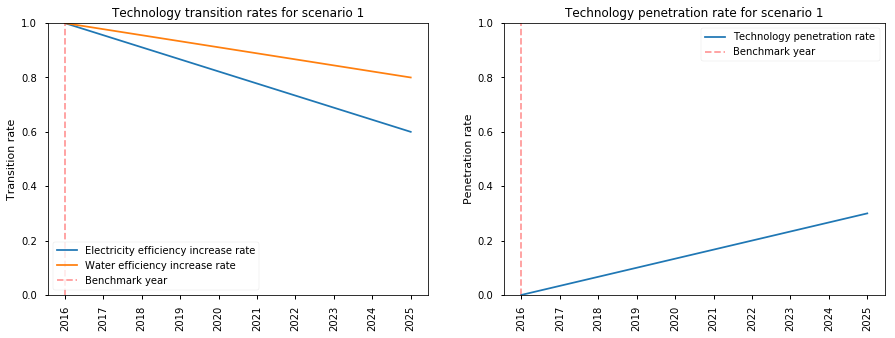

In [6]:
plot_transition_rate(
    {"Technology penetration rate": pr,
     "Electricity efficiency increase rate": Elec,
     "Water efficiency increase rate": Water},
     "scenario 1", start_year=2016, end_year=2025)

#### Reduce consumption

The actual modifications on the sample is performed by the `reduce_consumption()` function. The function requires as input the following parameters:

1. A base file name for the samples (in case of implementing the resample method).
2. The sample year (in this case generated within the loop via `range(2010, 2031)`.
3. The penetration rate for the sample year (iterated from vector `pr`).
4. The predefined `sampling_rules`.
5. A dictionary containing the efficiency rates for specific variables. (in this case for Electricity and Water).
6. A name for the scenario. 

In [7]:
for y, p, elec, water in zip(range(2016, 2026), pr, Elec, Water):
    _ = reduce_consumption(
        file_name,
        y, p, sampling_rules,
        {'Electricity':elec, 'Water':water},
        scenario_name = "scenario 1")

00.00%      both       reduction; efficiency rate 00.00%;              year 2016 and penetration rate 00.00
00.15%   Electricity   reduction; efficiency rate 04.44%;              year 2017 and penetration rate 00.03
00.07%      Water      reduction; efficiency rate 02.22%;              year 2017 and penetration rate 00.03
00.59%   Electricity   reduction; efficiency rate 08.89%;              year 2018 and penetration rate 00.07
00.30%      Water      reduction; efficiency rate 04.44%;              year 2018 and penetration rate 00.07
01.31%   Electricity   reduction; efficiency rate 13.33%;              year 2019 and penetration rate 00.10
00.67%      Water      reduction; efficiency rate 06.67%;              year 2019 and penetration rate 00.10
02.33%   Electricity   reduction; efficiency rate 17.78%;              year 2020 and penetration rate 00.13
01.18%      Water      reduction; efficiency rate 08.89%;              year 2020 and penetration rate 00.13
03.66%   Electricity   reduc

In [8]:
Elec  = transition_rate(0.0, 0.5, default_start=2016, default_end=2025)
Water = transition_rate(0.0, 0.3, default_start=2016, default_end=2025)
pr    = transition_rate(0.0, 0.6, default_start=2016, default_end=2025)

By modifying the growht rates we can create different scenarios.

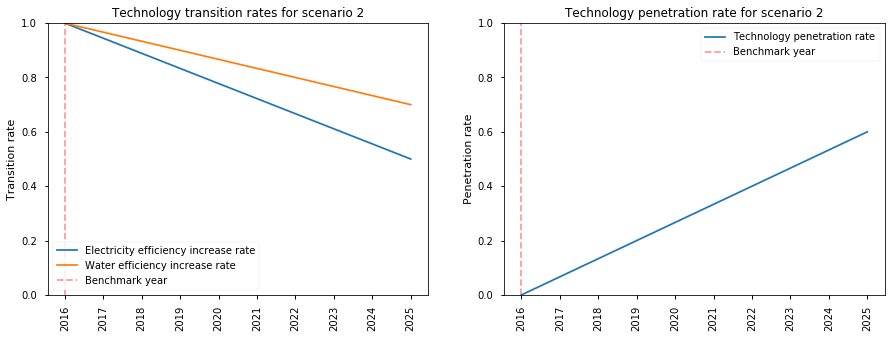

In [9]:
plot_transition_rate(
    {"Technology penetration rate": pr,
     "Electricity efficiency increase rate": Elec,
     "Water efficiency increase rate": Water},
     "scenario 2", start_year=2016, end_year=2025)

In [10]:
for y, p, elec, water in zip(range(2016, 2026), pr, Elec, Water):
    _ = reduce_consumption(
        file_name,
        y, p, sampling_rules,
        {'Electricity':elec, 'Water':water},
        scenario_name = "scenario 2")

00.00%      both       reduction; efficiency rate 00.00%;              year 2016 and penetration rate 00.00
00.36%   Electricity   reduction; efficiency rate 05.56%;              year 2017 and penetration rate 00.07
00.22%      Water      reduction; efficiency rate 03.33%;              year 2017 and penetration rate 00.07
01.47%   Electricity   reduction; efficiency rate 11.11%;              year 2018 and penetration rate 00.13
00.89%      Water      reduction; efficiency rate 06.67%;              year 2018 and penetration rate 00.13
03.29%   Electricity   reduction; efficiency rate 16.67%;              year 2019 and penetration rate 00.20
02.01%      Water      reduction; efficiency rate 10.00%;              year 2019 and penetration rate 00.20
05.84%   Electricity   reduction; efficiency rate 22.22%;              year 2020 and penetration rate 00.27
03.56%      Water      reduction; efficiency rate 13.33%;              year 2020 and penetration rate 00.27
09.16%   Electricity   reduc